## Final Project Submission

Please fill out:
* Student name: Aaron Lee
* Student pace: self paced
* Scheduled project review date/time: May 11, 3:30PM
* Instructor name: Jeff Herman
* Blog post URL: https://medium.com/@sciencelee/making-plots-with-the-pandas-groupby-ac492941af28


# Background

Our client sees the other big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but need help in understanding the movie industry. This project will provide a data analysis and presentation that explores what type of films are currently doing the best at the box office. We will translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.

# TMDB database
For our research, we will be using "The Movie Database" (TMDB) API to access the the box office info we need.  TMDB has access to over half a million movies and provides detailed data about genres, budgets, revenues, and other data we will need for our project.  Below are some examples of API calls for TMDB.  

## Accessing database
Below is the code we used to access our local API keys for TMDB.  
API tokens and keys can be attained at https://www.themoviedb.org/

In [2]:
# Access TMDB
import json
import pandas as pd
import seaborn as sns

def get_keys(path):
    #  retrieve your key/token from json file
    with open(path) as f:
        return json.load(f)
    
your_path = "/Users/aaronlee/.secret/tmdb_api.json"  # Make a json file that stores your key
keys = get_keys(your_path)

api_key = keys['api_key']
api_key4 = keys['api_key4']  # some searches require version 4

load_from_file = True  # we will normally load data from the saved file.  The data query is time intensive.
sns.set_context("talk")
sns.set_style('darkgrid')

## TMDB database queries

### URLs for TMDB
The TMDB database can be queried as shown in the code below.  Many examples can be found online, and the developer API guide on the website is very useful.

This is the base url for accessing TMDB
`base_url = 'https://api.themoviedb.org/3/`


You can add the following to the url for more specific searches
- `/person/person_id` (actors/directors info)
- `/movie/movie_id` (movie details)
- `/keywords/[keys]` (general search query)
- `/discover/movie` (get movies collections)


## Sample queries
### 2017 films in order of revenue
```python
params = {'primary_release_year': 2017,
          'sort_by': 'revenue.desc'
         }
```
### Highest revenue for a Tom Cruise scifi movie
```python
params = {'with_genres': 878,
          'with_cast': 500,
          'sort_by': 'revenue.desc'
        }
```
A sample request using the params above might look like this:
```python 
response = requests.get(base_url + 'discover/movie?api_key=' +  api_key, params=params)
```
 
## Results
The response from a query would contain detailed data located in ` response.json()['results']`

# Selecting our sample set

## Query the movies
First, we will create an API request to get 5000 movies from the past ten years sorted by budget (2015-2019).  We chose to sort by budget instead of revenue to include flops as well as box office winners.  We assume our client will be making traditional small to big budget films, and not indie films.  This will give a large cross section of recent movies which have gone into wide theater release. 

The 

The function `movie_selection_query` is used to retrieve a list of our results.  It fetches the data by pages with 20 movies per page.

In [30]:
import requests

def movie_selection_query(n, start_year, end_year):
    """Get a list of movie data.
    Args:
        n (int): number of movies to grab.
        start_year (int): earliest production year for movies returned
        end_year (int): latest production year for movies returned
    Returns:
       list: each index is a dict representing api results for single movie.
    """
    pages = 1 + n // 20 # db returns 20 results per page
    list_of_dicts = []  # list to be returned
    print("Fetching page ", end=(""))

    for i in range(1, pages + 1):
        # each iteration and api call is for a single page (20 movies)
        params = {
                  'primary_release_year.gte': start_year,
                  #'primary_release_year.lte': end_year,
                  'sort_by': 'budget.desc',
                  'page': i,
                  'adult': False}
        
        #Fetch Movie Data
        response = requests.get(base_url + 'discover/movie?api_key=' +  api_key, params=params)
        print(i, end=(','))
        # Go through results and add each to movie dict
        for movie in response.json()['results']:
            list_of_dicts.append(movie)
    
    print('-fetched all pages')
    return list_of_dicts[:n]


base_url = 'https://api.themoviedb.org/3/'

sample_size = 100 # our actual sample will be 5000 films.  This is only for demonstration
start_year = 2010  
end_year = 2019  

if not load_from_file:
    # load from file loaded with keys
    all_my_movies = movie_selection_query(sample_size, start_year, end_year)
    
df_clean.columns

Index(['belongs_to_collection', 'budget', 'genres', 'id', 'imdb_id',
       'original_language', 'original_title', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'title', 'vote_average',
       'vote_count', 'release_year', 'release_month',
       'revenue_to_budget_ratio', 'franchise'],
      dtype='object')

## Get all the movie id numbers from the query
The previous code retrieved the basic info for each movie.  This includes the movie 'id' number which will help us fetch the detailed info for each movie.  

Below, we extract all the movie 'id's from the previous query.  

In [4]:
if not load_from_file:
    all_my_movies[0]  # look at data for first movie (it seems to be an erroroneous response)
    movie_ids.pop(0)  #  The first item from the query is popped from the list.  Leaving it in causes error reading.
    # lets grab all of the movie numbers
    movie_ids = [movie['id'] for movie in all_my_movies]

## Make API call for each movie to grab detailed info
Now that we can the movie 'id' for TMDB, we can do a detailed movie api call for all of the selected movies.  This data includes: title, revenue, budget, runtime, etc.  

In [5]:
import os

def fetch_all_movies(movie_ids, path):
    """
    Fetches each individual movie details with query from TMDB
    Writes the results to csv for later use.
    Args:
        movie_ids (list):  all movie ids for our data project
        path (string): where we want our file to be stored
    Returns:
       
    """
    all_movie_details = []
    i = 1
    print("Fetching movies")
    for movie in movie_ids:
        #Fetch Movie Data
        #print(movie, end=',')
        print('', end='.')
        movie_response = requests.get(base_url + 'movie/' + str(movie) + '?api_key=' +  api_key)
        #print(movie_response)
        all_movie_details.append(movie_response.json())
        i += 1
    print("--end of queries.")
    df = pd.DataFrame(all_movie_details)

    output_file = os.path.join(path,'tmdb-movies.csv')

    f = df.to_csv(output_file, index=False)
    return all_movie_details, f



path = "/Users/aaronlee/flatiron-ds-course/module01/final_project"


if load_from_file:
    # if the query is valid for project, all data will be stored in file tmdb-movies.csv
    df = pd.read_csv('tmdb-movies.csv')
else:
    # we need to do query and write it to file
    all_movie_details, f = fetch_all_movies(movie_ids, path)
    df = pd.DataFrame(all_movie_details)
    output_file = os.path.join(path,'tmdb-movies.csv')
    df.to_csv(output_file, index=False)
    # After running the query, change load_from_file back to True to prevent unecessary queries

# Clean the data
With detailed info on every movie in our search now stored in a Pandas DataFrame, we will now clean our data for further exploration.  We start with 5000 movies in the dataframe. 


## Remove missing or incomplete data 
We chose to eliminate movies in the data set that are not fully updated with data we will be using.  TMDB movie data is pretty thorough, and less than 1 percent of the movies are lacking necessary info.  

Row entries with null values in the columns (id, 'runtime', 'release_date', 'imdb_id') were dropped from the set.

Unnecessary columns were eliminated for convenience ('adult', 'backdrop_path', 'homepage', 'video', 'status_code', 'status_message', 'status', 'tagline', 'poster_path', 'overview')

No NaN values remain in the set after these lines and columns are dropped.  

We also convert the 'release_date' column to datetime objects so we can work with them numerically and compare them.

In [6]:
df.isna().sum()  # found some without id, runtime, release_date.

df.dropna(subset=['id', 'runtime', 'release_date', 'imdb_id'], inplace=True)  # Eliminates ~30 entries

# We choose to drop the columns that are not necessary for our study. 
df_clean = df.drop(['adult', 'backdrop_path', 'homepage', 'video', 'status_code', 'status_message', 
                    'status', 'tagline', 'poster_path', 'overview'], axis=1)

# convert dates to datetime objects for comparison
datetimes = pd.to_datetime(df["release_date"])
df_clean['release_date'] = datetimes

## Additional columns for our analysis
We need a few columns which are not currently in our dataset. 
We will add:
- release_month
- release_year
- revenue_to_budget_ratio (measure of profitability)

In [7]:
# create series for new cols
release_year = df_clean['release_date'].map(lambda x: int(x.year))
release_month = df_clean['release_date'].map(lambda x: int(x.month))
revenue_to_budget_ratio = df_clean['revenue'] / df_clean['budget']
franchise = df_clean['belongs_to_collection'].notna()


# add series as cols to df
df_clean['release_year'] = release_year
df_clean['release_month'] = release_month
df_clean['revenue_to_budget_ratio'] = revenue_to_budget_ratio
df_clean['franchise'] = franchise

## Selection criteria
Now that we have eliminated missing or corrupt data, we will further reduce our dataframe to include only what we need for analysis.

In this project, we attempt to look at major trends in movies for a new production company, so we will check the data as it relates primarily to budget and revenue.  We will inform the company what types of movies will be profitable going forward, and potential ways to maximize profits in the current film industry.

Selection criteria for movies in our investigation
- Movies with runtimes over one hour. Eliminate shorts and bonus material videos.
- Movies with a budgets over \$500,000.  Eliminates some documentaries and smaller indie films.  
- Movies with revenue over \$500,000.  Eliminates small theatrical releases.
- Movies from last 10 years.  Only keep contemporary data
- No data from 2020 due to COVID-19 impacts

We will split the movies into two dataframes.  df5 will represent the past 5 years of movies for contemporary data.  df10 will represent the past 10 for longer industry trends.

In [26]:
# Filtering data using criteria above
# 10 years of movies
df10 = df_clean[(df_clean['runtime'] > 60)
        & (df_clean['revenue'] > 5e5) 
        & (df_clean['budget'] > 5e5)
        & (df_clean['release_year'] >= 2010)
        & (df_clean['release_year'] < 2020)
       ]  # get rid of shorts and non voted

# 5 years of movies
df5 = df_clean[(df_clean['runtime'] > 60) 
        & (df_clean['revenue'] > 5e5) 
        & (df_clean['budget'] > 5e5)
        & (df_clean['release_year'] >= 2015)
        & (df_clean['release_year'] < 2020)
       ]  # get rid of shorts and non voted


#. df5.isna().sum()  # all the data will work for our purposes.  We might later drop some cols to simplify#


Index(['belongs_to_collection', 'budget', 'genres', 'id', 'imdb_id',
       'original_language', 'original_title', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'title', 'vote_average',
       'vote_count', 'release_year', 'release_month',
       'revenue_to_budget_ratio', 'franchise'],
      dtype='object')

# Budget and Revenue 
Our investigation will be focused on the budget and revenues of movies.
We begin by exploring these for our set of movies. by looking at the central tendencies of each.

## Centrality of budget and revenue

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Budget and Revenue (past 5 years)\n")

for col in ['budget', 'revenue']:
    print("{} Centeral Tendency".format(col.title()))
    print('Min Budget: {:.2f} Million'.format(df5[col].min() / 1e6))
    print('Max Budget: {:.2f} Million'.format(df5[col].max() / 1e6))
    print('Mean Budget: {:.2f} Million'.format(df5[col].mean() / 1e6))
    print('Median Budget: {:.2f} Million'.format(df5[col].median() / 1e6))
    print('First Quartile (25%): {:.2f} Million'.format(df5[col].quantile(0.25) / 1e6))
    print("IQR (25-50%): {:.2f} Million".format((df5[col].quantile(0.75) - df5[col].quantile(0.25)) / 1e6))
    print('Third Quartile (75%): {:.2f} Million'.format(df5[col].quantile(0.75) / 1e6))
    print("Std Dev: {:.2f} Million".format(df5[col].std() / 1e6))
    print()

Budget and Revenue (past 5 years)

Budget Centeral Tendency
Min Budget: 0.70 Million
Max Budget: 300.00 Million
Mean Budget: 52.21 Million
Median Budget: 30.00 Million
First Quartile (25%): 12.00 Million
IQR (25-50%): 57.00 Million
Third Quartile (75%): 69.00 Million
Std Dev: 56.85 Million

Revenue Centeral Tendency
Min Budget: 11.82 Million
Max Budget: 2068.22 Million
Mean Budget: 193.34 Million
Median Budget: 80.25 Million
First Quartile (25%): 34.49 Million
IQR (25-50%): 175.37 Million
Third Quartile (75%): 209.85 Million
Std Dev: 287.37 Million



Promotional and other costs are not considered as part of this study, so the true results are incomplete.  However, mean revenues are more than five times the mean budget.  Movies with budgets in the Third Quartile (90M USD) are still smaller than revenues in the First Quartile (109M USD).  This is further illustrated by the box plots below.

*Hollywood Reporter* https://www.hollywoodreporter.com/news/200-million-rising-hollywood-struggles-721818reporter article shows that worldwide promotion for large theatrical releases is currently in the 150 to 200 million dollar range.

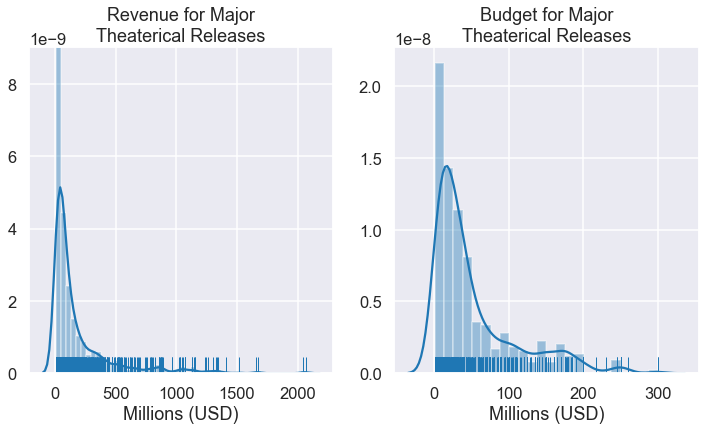

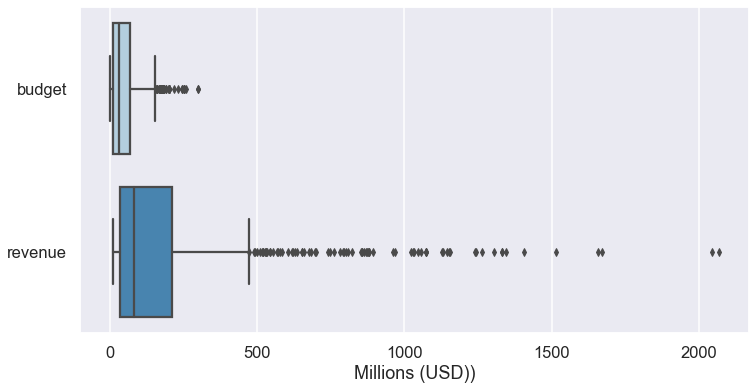

In [10]:
# df with just revenue and budget
df_money = df5[['budget', 'revenue']].copy()

def revenue_budget_box(df):
    # create a boxplot of revenue and budget
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=df, palette='Blues', orient='h')
    xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels)
    ax.set(xlabel="Millions (USD))")

def revenue_budget_dist(df, ax, col='revenue'):
    # Create a distribution  plot
    sns.distplot(df[col], ax=ax, rug=True) 
    ax.set_title("{} for Major\nTheaterical Releases".format(col.title()))
    xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels)
    ax.set(xlabel='Millions (USD)')

f, ax = plt.subplots(1,2,figsize=(12,6))
revenue_budget_dist(df_money, ax[0], col='revenue')
revenue_budget_dist(df_money, ax[1], col='budget')
revenue_budget_box(df_money)


Both budget and revenue are left skewed, and returns tend to be significantly higher than budgets, with revenue outliers on the high side being far more prevalent than budget outliers.

# What variables affect revenue?
Now we will attempt to find correlations between movie attributes and the revenue data.
Specifically, our client wants to know what kind of movie they should be making for the current market.  We must look at genre, sequels, release_date, etc.

Text(0.5, 1, 'Pearson Coefficients')

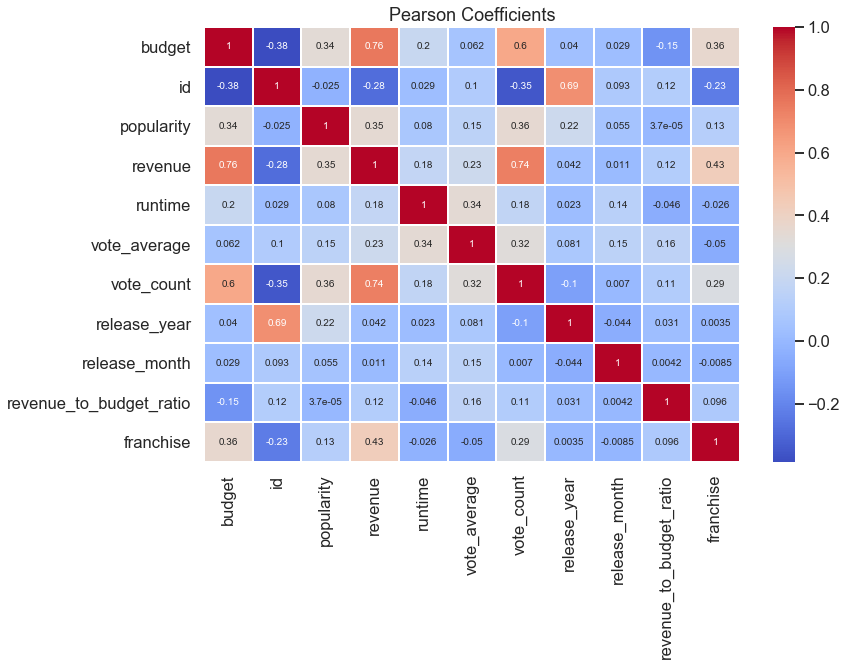

In [11]:
import numpy as np

pearsoncorr = df5.corr(method='pearson') 
plt.figure(figsize=(12,8))

# make a heatmap out of correlation df 
ax = sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            annot=True,
            linewidth=1)

#df.columns
ax.set_ylim(11.0, 0)  # not needed with old Matplotlib version.  
ax.set_title('Pearson Coefficients')


The coefficients above that stick out as having high positive corelations are **budget** and **revenue**.  of course vote_count is also linked closely to revenue (people vote on movies they see).  Surprisingly, vote_average (the user opinion) is not highly correlated as you might think.  

From the above heatmap, we should look at the following numerical data:
- budget: high degree of correlation with revenue
- runtime: low degree correlation with revenue
- vote_average: low degree of correlation with revenue 

There may also be correlation with other some categorical information about the movie such as:
- is the movie a sequel or part of a franchise?
- what is the genre of the movie?
- what month or date was the release?

# Relationship between a movie's budget and revenue
The numerical category with the highest correlation is user votes for the movie.  Making quality movies that are liked by audiences is likely the best way to guarantee high returns.  Additionally, the budget seems to have a high degree of correlation with revenue, and we will look at that relationship now. 

After looking at how correlation varied by budget, we decided to use a 2nd order curve to fit the scatterplot of revenue vs budget.  Especially on the high end, the more you spend, the more you make.

[Text(6.800000000000004, 0.5, 'Revenue ($MM)'),
 Text(0.5, 6.800000000000026, 'Budget ($MM)'),
 Text(0.5, 1, 'Pearson Corr: 0.76')]

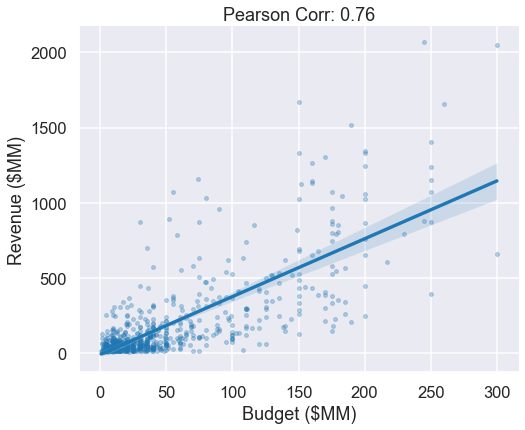

In [12]:
# calculate pearson corr for budget revenue
pval = df5[['budget', 'revenue']].corr(method ='pearson').iloc[0,1]

# make regression plot
fgrid = sns.lmplot(data=df5, x='budget', y='revenue', height=6, aspect=1.2, 
                   scatter_kws={"s":15,'alpha':0.3},
                   order=1
                  )

# annotate with pval
ax = fgrid.axes[0,0] 
ax.set_alpha(0.5)

# labels to show in millions
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ylabels = ['{:d}'.format(int(y/1000000)) for y in ax.get_yticks()]
ax.set_yticklabels(ylabels)

# set graph attributes
ax.set(xlabel='Budget ($MM)', ylabel='Revenue ($MM)', title='Pearson Corr: {:.2f}'.format(pval))

## What portion of total revenues do the big budget films have?


In [13]:
def budget_trimmed_df(df, low, high):
    # return a df between the low and high quantile
    dfq = df[(df['budget'] > df['budget'].quantile(low)) & (df['budget'] <= df['budget'].quantile(high))]  
    return dfq

dfq = budget_trimmed_df(df5, 0.95, 1)  # df quantile (cut between quantiles)
percentage_blockbuster_profits = dfq['revenue'].sum() / df5['revenue'].sum()
print("Big budget films earn {:.1%} of all revenues.".format(percentage_blockbuster_profits))

Big budget films earn 22.9% of all revenues.


# How has this relationship held up over time?

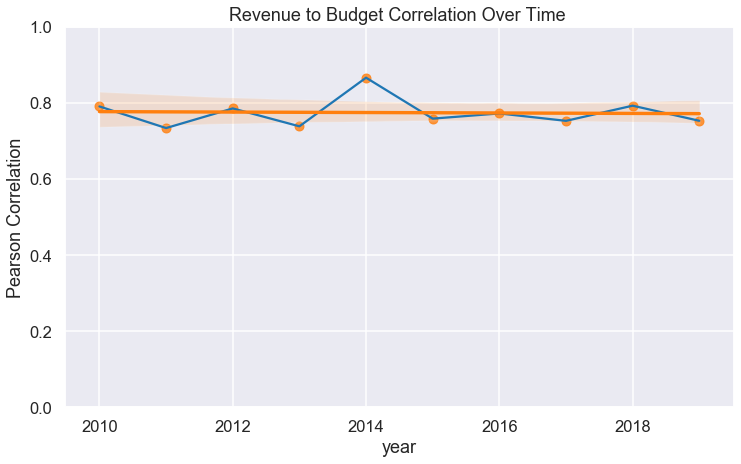

In [14]:
# Store a list of pearson coeff to represent how closely correlation has followed over years.

def get_corrs(df, start_year, end_year):
    # get pearson coeff for each year
    corrs = [] 
    for year in range(start_year, end_year + 1):
        rev = df[df['release_year'] == year]['revenue']  # slice and compare the two series
        bud = df[df['release_year'] == year]['budget']
        c = rev.corr(bud, method='pearson')
        corrs.append({'year': int(year), 'Pearson Correlation': c})
    
    return corrs
 

corrs = get_corrs(df10, 2010, 2019)
df_corrs = pd.DataFrame(corrs)
    
plt.figure(figsize=(12,7))
ax = sns.lineplot(data=df_corrs, x='year', y='Pearson Correlation')
ax.set_ylim(0,1)
ax.set_title("Revenue to Budget Correlation Over Time ")
sns.regplot(data=df_corrs, x='year', y='Pearson Correlation')

The releationship between budget and revenue seems to hold relatively constant over the past 10 years, so this can be considered to be a very stable correlelation for movie success.

## Return on Investment for big budget films

Perhaps big budget films have a different correlation between budget and revenue than films at large.  If we find that high end big budget films are disproportionaly successful, then our client should follow suit and outspend to get big returns.  

We will look at films that are in the top quantile half for budgets and compare them to the rest of the field.

Text(0.5, 1.0, 'Films above median budget')

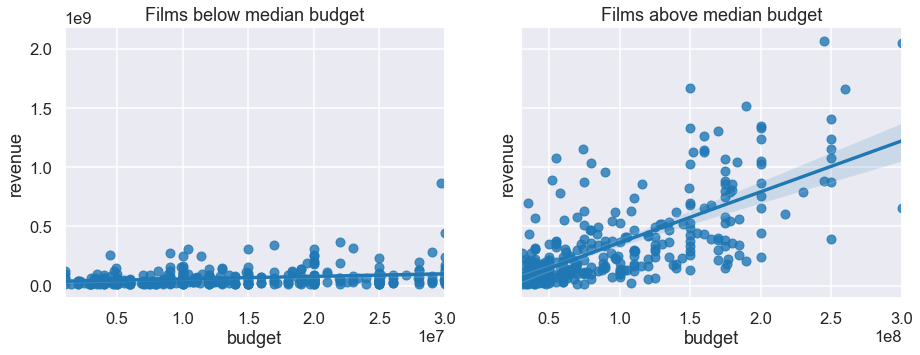

In [15]:
# look at plots of revenue and budget, but split up by the quantile/quartile of budget 

def lmplot_by_budget(df, low, high, ax):
    """
    Make a plot of revenue vs budget, but specify the range of budgets using low and high quantile
    Plot will show all movies between the low and high quantile
    Args:
        df (Pandas.DataFrame):  cleaned df of movies from TMDB per previous functions
        low (float): low budget quantile
        high (float): high budget quantile
    Returns:
    """
    dfq = df[(df['budget'] > df['budget'].quantile(low)) & (df['budget'] <= df['budget'].quantile(high))]  
    pval = dfq[['budget', 'revenue']].corr(method ='pearson').iloc[0,1]

    # make regression plot for top quartile
    sns.regplot(data=dfq, x='budget', y='revenue', ax=ax)
    

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5), sharey=True)

# this was originally set up to do plots of quartiles, but it reduced the reliability of the data by doing so.
for i in range(2):
    lmplot_by_budget(df5, 0.5 * i, 0.5 * (i + 1), ax[i])
    

ax[0].set_title('Films below median budget') 
ax[1].set_title('Films above median budget') 

## Do big budgets also have a better ROI?
It is obvious that big budgets yield big returns, but are there diminishing returns for big budgets.  Where does the profitability have it's maximum value.

[5.98, 10.0, 15.0, 22.0, 30.0, 40.0, 55.0, 87.933055, 150.0, 300.0]


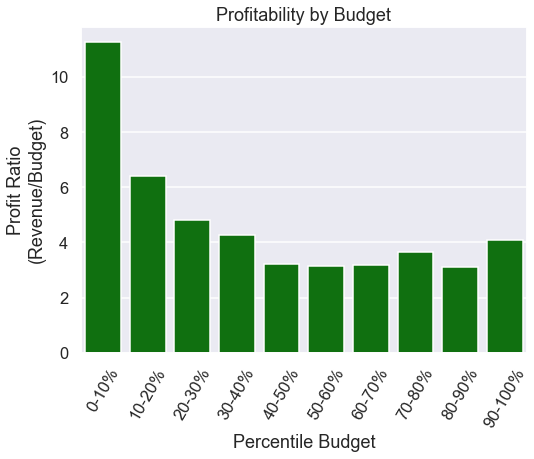

In [16]:
# Do big budget films actually show better revenue/budget ratios
profitability_percentiles = []
corresponding_budgets = []

for i in range(10):
    df_p = df5[(df5['budget'] > df5['budget'].quantile(i/10)) & (df5['budget'] <= df5['budget'].quantile((i+1)/10))]
    p = df_p['revenue'].mean() / df_p['budget'].mean()
    profitability_percentiles.append(p)
    corresponding_budgets.append(df_p['budget'].max() / 1e6)

print(corresponding_budgets)  # upper end budgets for each decile

def plot_ratio(raw_data):
    # Plot the profitability by quantile
    data = np.array(raw_data)
    x = np.arange(start=0, stop=10, step=1)
    width = 0.2  # width of bar
    plt.figure(figsize=(8,6))
    ax = sns.barplot(x, data, color='green')
    ax.set_title('Profitability by Budget')
    ax.set(xlabel='Percentile Budget', ylabel='Profit Ratio\n(Revenue/Budget)')
    xlabel = ['{}-{}%'.format(n*10, (n+1)*10) for n in x]
    plt.xticks(x, xlabel, rotation=60)
    
    
plot_ratio(profitability_percentiles)

The result here was unexpected.  The lowest budget moveies (<6M) had the highest returns by a large margin.  Films with budgets under 22 million dollars outperfomed all other categories.

A strategy that could be used here is to make many small movies in lieu of single big budget films.

# Do movie franchises fare better than standalone films?

The database used for this study only shows if the film was part of a franchise, meaning that even the first film in a series would be categorized as any other franchise movie.  Since we generally expect that only successful movies are given sequels, this will greatly skew the result.  A closer look at true sequels might be a subject for further study.

Pearson Correlations:
	Franchise: 0.77
	No Franchise: 0.65
29.63% of movies in past five years are part of a franchise.
Franchise movies make up 58.636386% of all revenues.


<Figure size 720x864 with 0 Axes>

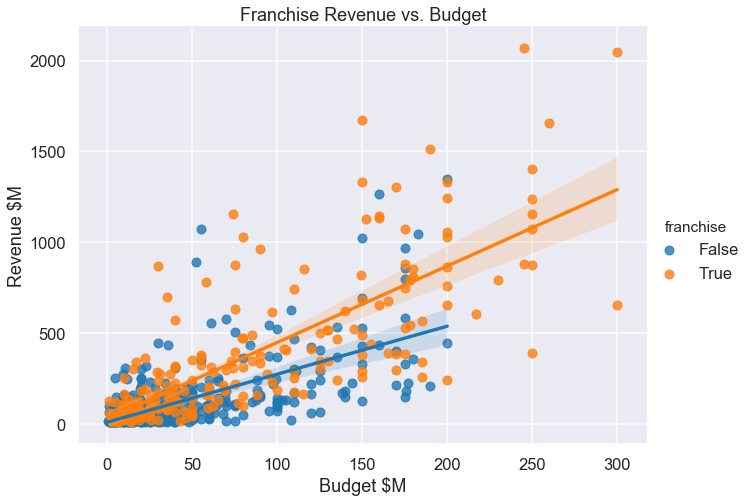

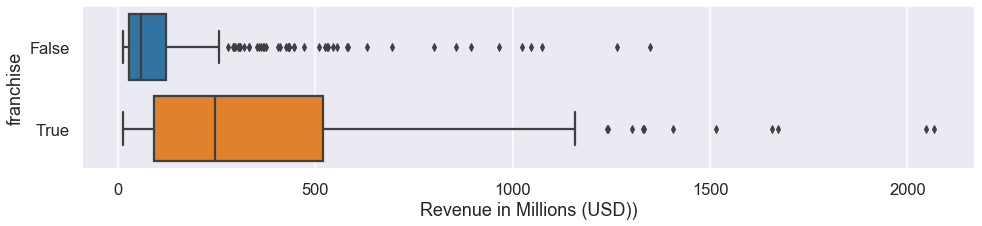

In [17]:
from scipy import stats


#slope, intercept, r_value, p_value, std_err = stats.linregress(df5['budget'],df5['revenue'])
#print("Slope:", slope)

# sns.lmplot returns a FacetGrid
plt.figure(figsize=(10,12))

fgrid = sns.lmplot(x="budget", 
                y="revenue", 
                hue="franchise", 
                data=df5, 
                height=7, 
                aspect=1.3
              )  

ax = fgrid.axes[0,0] # FacetGrid has axes we can talk to

# add Pearson
pval_yes = df5.loc[df5['franchise']==True, ['budget', 'revenue']].corr(method ='pearson').iloc[0,1]
pval_no = df5.loc[df5['franchise']==False, ['budget', 'revenue']].corr(method ='pearson').iloc[0,1]
print("Pearson Correlations:\n\tFranchise: {:.2f}\n\tNo Franchise: {:.2f}".format(pval_yes, pval_no))

xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ylabels = ['{:d}'.format(int(y/1000000)) for y in ax.get_yticks()]
ax.set_yticklabels(ylabels)

ax.set(xlabel='Budget $M', ylabel='Revenue $M', title='Franchise Revenue vs. Budget')


# percentage of movies that are franchises
print("{:.2%} of movies in past five years are part of a franchise.".format(df5['franchise'].sum() / len(df5)))


df_sequels = df5.loc[:, ['franchise', 'revenue']]

plt.figure(figsize=(16,3))
ax = sns.boxplot(data=df_sequels, x='revenue', y='franchise', orient='h')

xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ax.set(xlabel="Revenue in Millions (USD))")

# sequels share of market
sequel_revenue_share = df5.loc[df5['franchise']==True]['revenue'].sum() / df5['revenue'].sum()
print("Franchise movies make up {:%} of all revenues.".format(sequel_revenue_share))


In [18]:
# What is the profitability of sequels.  So we can later compare to genres.

franchise_breakdown = df5.groupby(['franchise']).mean().sort_values('revenue_to_budget_ratio')['revenue_to_budget_ratio']

'Franchise movies are {:.1%} more profitable.'.format((franchise_breakdown[1] - franchise_breakdown[0]) / franchise_breakdown[1])

'Franchise movies are 27.8% more profitable.'

Franchise films earn about 40% more than other films.  They have a slightly stronger correlation with revenue.  They are prevalent in the film industry (make up 29.65% of films).  They earn 58.6% of all revenue.  Making sequels is also an effective strategy for profit.

# What about genres?

TMDB provides a dictionary of all genres provided for a movie (up to 3).  This makes it difficult to categorize a movie by a single genre.  A "RomCom" might best be described by both categories, but the database only has categores of Romance and Comedy separate.  The first category is the primary category for the movie and will be used for the following analysis.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3974 entries, 0 to 0
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   genre         3974 non-null   object        
 1   revenue       3974 non-null   float64       
 2   release_date  3974 non-null   datetime64[ns]
 3   budget        3974 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 155.2+ KB


Text(0.5, 1.0, 'Mean Revenue and Budget by Genre')

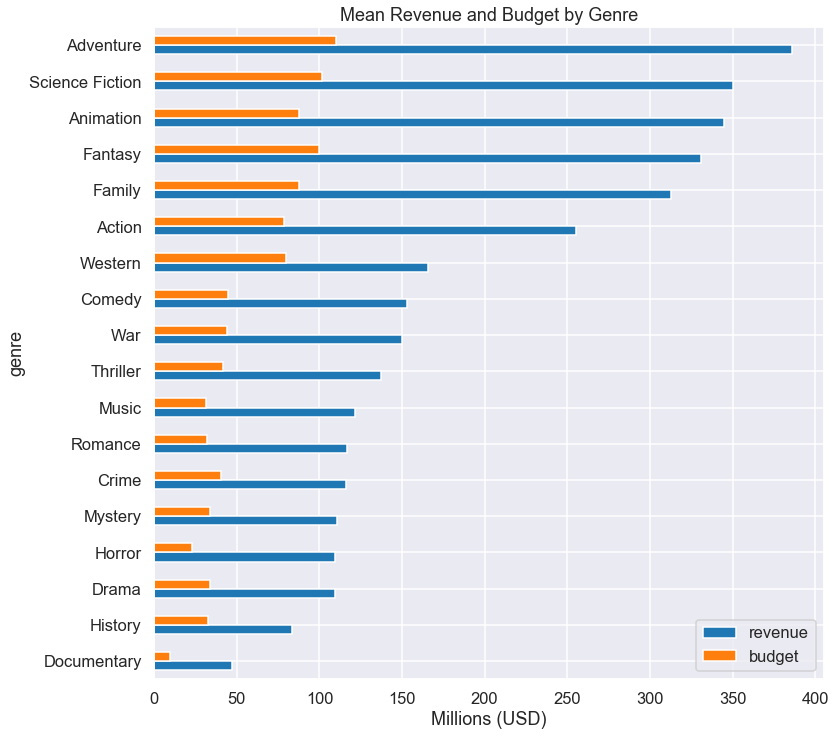

In [19]:
df_genres = df10.copy()
df_genres = df_genres.loc[:, ['genres', 'revenue', 'release_date', 'budget']]


# my dictionaries read in as strings for my genre!!!
# lets convert them back
df_genres['genres'] = df_genres['genres'].map(lambda x: eval(x))


# # make df that has separate entry for each genre.  A movie with three genres would effect three categories.
# expanded df
df_gen_exp = pd.DataFrame({'genre':[], 'revenue':[], 'release_date':[], 'budget':[]})


for col, row in df_genres.iterrows():
    try:
        for genres in row['genres']:
            new = pd.DataFrame({'genre':[genres['name']], 'revenue':[row['revenue']], 'release_date':[row['release_date']], 'budget':[row['budget']] })
            df_gen_exp = pd.concat([df_gen_exp, new])
    except Exception as e:
        print(e)

        
df_gen_exp.info()
    
df_genres_grouped = df_gen_exp.groupby(['genre']).mean().sort_values('revenue')
# df_genres_grouped = df_genres_grouped[['revenue', 'budget']]
df_gen_exp.reset_index()

df_genres_grouped
                                 
ax = df_genres_grouped.plot.barh(figsize=(12,12))

xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ax.set(xlabel='Millions (USD)')
ax.set_title("Mean Revenue and Budget by Genre")



In [20]:

df_gen_exp['release_year'] = pd.DatetimeIndex(df_gen_exp['release_date']).year
df_genres_by_year = df_gen_exp.copy()
df_genres_by_year


df_plot = df_genres_by_year.groupby(['release_year', 'genre']).mean().unstack()
df_plot


revenue                                            \
genre               Action     Adventure     Animation        Comedy   
release_year                                                           
2010          1.604780e+08  2.815479e+08  3.934894e+08  1.234809e+08   
2011          1.866155e+08  3.340435e+08  2.960908e+08  1.325578e+08   
2012          2.574271e+08  4.462577e+08  3.287246e+08  1.511102e+08   
2013          2.281996e+08  3.321033e+08  2.925334e+08  1.314442e+08   
2014          3.012014e+08  4.057142e+08  2.886556e+08  1.488812e+08   
2015          3.089365e+08  3.689574e+08  3.495369e+08  1.366062e+08   
2016          2.025835e+08  3.923256e+08  4.555942e+08  1.886000e+08   
2017          3.437992e+08  3.990113e+08  3.176883e+08  2.101231e+08   
2018          3.523948e+08  4.557789e+08  2.898016e+08  1.378766e+08   
2019          2.415539e+08  4.852297e+08  4.651227e+08  1.839449e+08   

                                                                     \
genre                Crime  Documentary         Drama        Family   
release_year                                                          
2010          8.176359e+07  117224271.0  9.899663e+07  2.986681e+08   
2011          1.458414e+08   43910006.0  8.096138e+07  2.086386e+08   
2012          1.337308e+08   33063478.0  1.480703e+08  2.821551e+08   
2013          1.214427e+08          NaN  8.668054e+07  3.480158e+08   
2014          8.999697e+07          NaN  1.103695e+08  2.621811e+08   
2015          8.162292e+07          NaN  1.168821e+08  3.147347e+08   
2016          1.058402e+08   13000000.0  9.966359e+07  4.294449e+08   
2017          1.824258e+08          NaN  1.273280e+08  3.115939e+08   
2018          6.430843e+07          NaN  1.154166e+08  2.775299e+08   
2019          1.840248e+08          NaN  1.349918e+08  4.155849e+08   

                                          ...        budget                \
genre              Fantasy       History  ...       Fantasy       History   
release_year                              ...                               
2010          2.975767e+08  8.077690e+07  ...  1.007391e+08  1.630040e+07   
2011          3.329451e+08  6.471154e+07  ...  9.138333e+07  3.416667e+07   
2012          3.849121e+08  2.250723e+08  ...  1.092347e+08  5.600000e+07   
2013          3.018637e+08  6.569294e+07  ...  1.184368e+08  1.843273e+07   
2014          3.201375e+08  1.053406e+08  ...  9.907385e+07  3.777914e+07   
2015          2.999771e+08  5.634034e+07  ...  7.809398e+07  2.922222e+07   
2016          3.580687e+08  6.841029e+07  ...  1.141627e+08  3.201250e+07   
2017          4.404673e+08  9.178042e+07  ...  1.060026e+08  4.114800e+07   
2018          3.131644e+08  5.421385e+07  ...  9.493684e+07  2.977542e+07   
2019          2.677452e+08  1.738785e+08  ...  8.219684e+07  5.618392e+07   

                                                                      \
genre               Horror         Music       Mystery       Romance   
release_year                                                           
2010          2.030714e+07  4.269328e+07  3.769136e+07  4.158209e+07   
2011          2.908333e+07  2.948667e+07  4.973333e+07  3.327519e+07   
2012          2.573077e+07  2.656532e+07  3.502857e+07  2.884348e+07   
2013          3.216667e+07  1.400000e+07  5.337500e+07  2.508405e+07   
2014          1.640000e+07  3.957500e+07  4.455556e+07  3.374439e+07   
2015          1.713846e+07  2.375000e+07  3.327500e+07  2.584211e+07   
2016          1.658728e+07  5.300000e+07  3.152065e+07  3.337400e+07   
2017          2.928889e+07  3.071817e+07  2.464286e+07  2.884282e+07   
2018          2.503333e+07  2.462500e+07  2.180000e+07  2.324671e+07   
2019          1.902941e+07  2.919571e+07  1.466667e+07  3.614064e+07   

                                                                       
genre        Science Fiction      Thriller           War      Western  
release_year                                                           
201

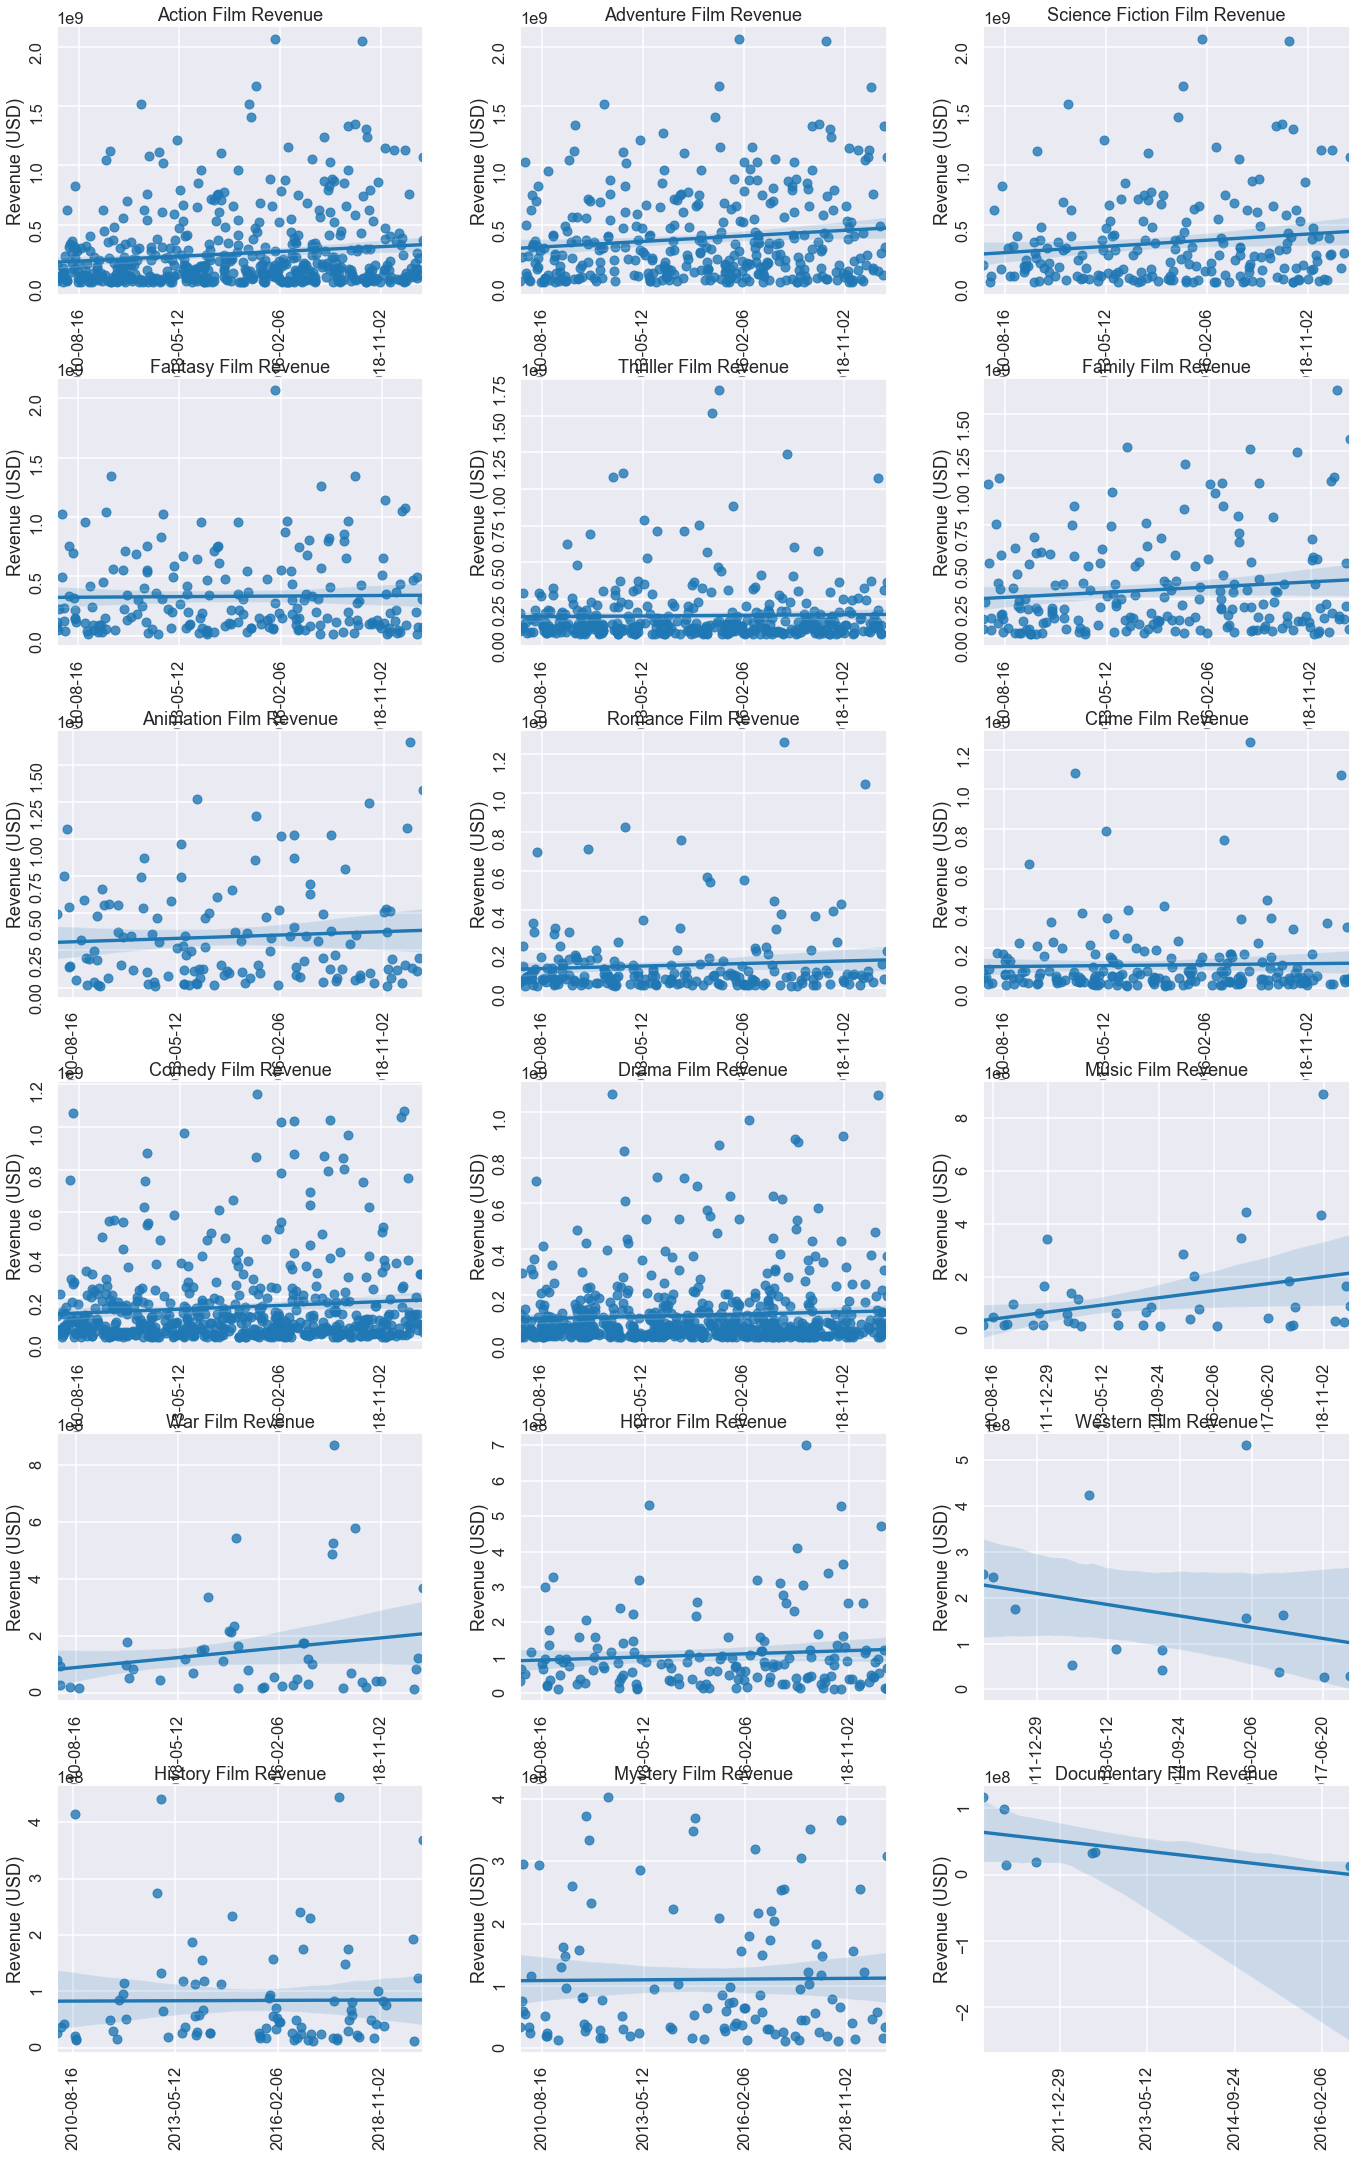

In [21]:
from datetime import datetime
from matplotlib import dates

# make a simple list of the genre names for the loop
genre_list = list(df_gen_exp['genre'].unique())
genre_list

#datetime.strptime('2000-04-01', %Y-%m-%d)
df_gen_exp2 = df_gen_exp.copy()

df_gen_exp2['date'] =  df_gen_exp2['release_date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d')) 
df_gen_exp2['datenum'] = df_gen_exp2['date'].apply(lambda x: dates.datestr2num(x))
# df_gen_exp
# df_gen_exp.info()


fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(20,30), sharey=False)
fig.tight_layout(pad=5)
sns.set_style('darkgrid')


for i, ax in zip(range(len(genre_list)), axes.flat):
    df1 = df_gen_exp2.loc[df_gen_exp2['genre'] == genre_list[i]]
    sns.regplot(x='datenum', y='revenue', data=df1, ax=ax)
    xlabels = ['{}'.format(datetime.strftime(dates.num2date(x), '%Y-%m-%d')) for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels)
    ax.tick_params(labelrotation=90)
    ax.set(title="{} Film Revenue".format(genre_list[i]), xlabel="", ylabel='Revenue (USD)')
    #ax.set_ylim(0, 800000000)


The most interesting results from the our look at genres, was the revenue and budget.  It seems that some genres like horror and mystery have a higher rate of return on their movies.  

140000000.0 380000000.0
700000.0 380000000.0
445148622.40000015 2068223624.0
0       2.545455
1       6.181818
2      10.500000
3      14.909091
4      19.400000
         ...    
115    32.666667
116    37.428571
117    42.000000
118    46.111111
119    51.000000
Name: release_week, Length: 120, dtype: float64


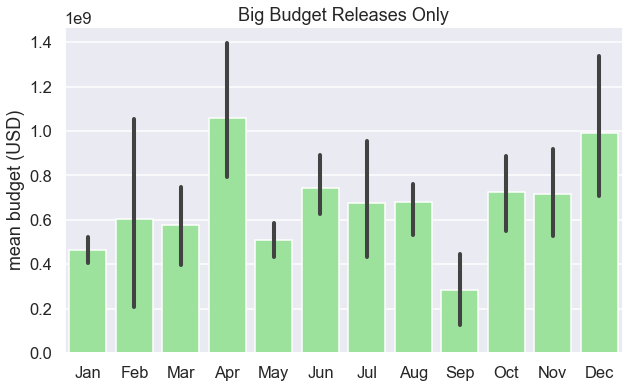

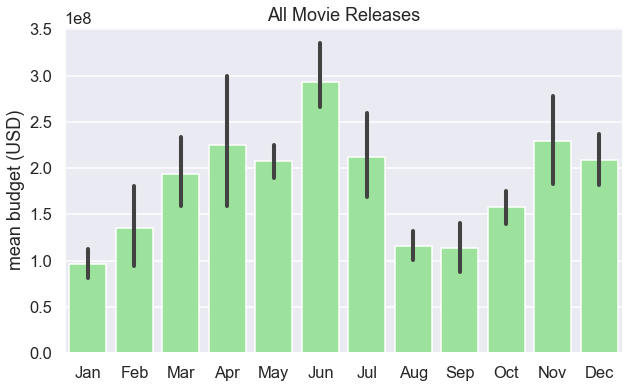

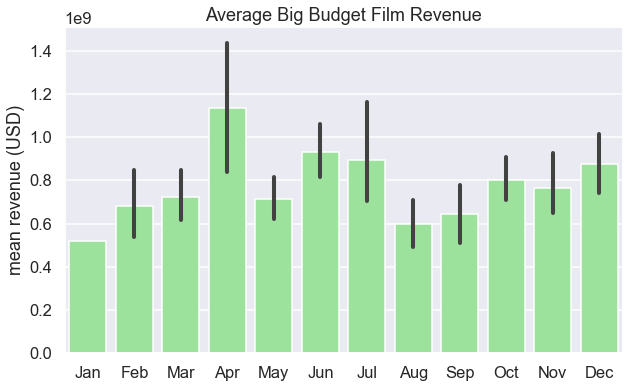

In [24]:
# investigate release date effect
import datetime as dt


def release_date_graph(my_df, lower_quantile=0, upper_quantile=1, yaxis='budget', graph_type='bar'):
    """Get a list of movie data.
    Args:
        my_df (pandas.DataFrame):  dataframe from original TMDB query
        lower_quantile (float): lowest quantile to include
        upper_quantile (float): hightest quantile to include
        yaxis (str): what column goes on yaxis ('budget' or 'revenue')
        graph_type (str): 'bar' or 'dist' or 'both'
    Returns:
       df_month (pandas.DataFrame: df used to create plot
       fig (matplotlib.figure.Figure): plt figure for further formatting
       ax (matplotlib.axes._subplots.AxesSubplot): plot axes for further formatting

    """
    # returns a df that has revenue by month info for plotting
    # sortby choices: revenue, budget
    df_month = my_df.loc[:, ['release_date', 'revenue', 'budget']]
    df_month['release_month'] = pd.DatetimeIndex(df_month['release_date']).month
    df_month['release_year'] = pd.DatetimeIndex(df_month['release_date']).year
    df_month['release_week'] = pd.DatetimeIndex(df_month['release_date']).map(lambda x: int(x.isocalendar()[1]))

    #print(df_month.head())

    # blockbuster will be 95th quantile
    low_gate = df_month[yaxis].quantile(lower_quantile)
    high_gate = df_month[yaxis].quantile(upper_quantile)
    print(low_gate, high_gate)
    df_month = df_month[(df_month[yaxis] < high_gate) & (df_month[yaxis] > low_gate)] 
    
    if graph_type == 'bar':
        df_month = df_month.groupby(['release_year', 'release_month']).mean().reset_index()
        fig, ax = make_barplot(df_month, lower_quantile, upper_quantile, yaxis=yaxis)
    elif graph_type == 'dist':
        fig, ax = make_distplot(df_month, lower_quantile, upper_quantile, yaxis=yaxis)

    return df_month, fig, ax


def make_barplot(df_month, lower_quantile, upper_quantile, yaxis='budget'):
    # if user selected bar
    fig = plt.figure(figsize=(10,6))
    ax = sns.barplot(data=df_month, x='release_month', y='revenue', color='lightgreen') 
    ax.set_title("Mean Revenue by Release Month (quantile {} to {})".format(lower_quantile, upper_quantile))
    xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticklabels(xlabels)
    ax.set(ylabel='mean {} (USD)'.format(yaxis))
    ax.set(xlabel="")
    return fig, ax

def make_distplot(df_month, lower_quantile, upper_quantile, yaxis='budget'):
    # if user selected dist
    fig = plt.figure(figsize=(10,6))
    ax = sns.distplot(df_month['release_month'], bins=12, kde=False)
    ax.set_title("Release Distribution (quantile {} to {})".format(lower_quantile, upper_quantile))
    ax.set(ylabel='Movies Released Each Month')
    xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set(xlabel="")
    return fig, ax

# quantiles allow us to investigate success of low or high budget movie by release date.
# we can also change the yaxis to look at either revenue or budget.  
# client may want to see when big budget movies are released, but also what months contain the highest revenue movies


df_month2, fig2, ax2 = release_date_graph(df10, lower_quantile=0.9, upper_quantile=1, yaxis='budget', graph_type='bar')  # can send in df5 or df10 for last 5 or 10 years of data
df_month1, fig1, ax1 = release_date_graph(df10, lower_quantile=0, upper_quantile=1, yaxis='budget', graph_type='bar')  # can send in df5 or df10 for last 5 or 10 years of data

df_month3, fig3, ax3 = release_date_graph(df10, lower_quantile=0.9, upper_quantile=1, yaxis='revenue', graph_type='bar') 

ax1.set_title("All Movie Releases")
ax2.set_title("Big Budget Releases Only")
ax3.set_title("Average Big Budget Film Revenue")
print(df_month1['release_week'])

We plotted the average revenues for movies based on the month of their release.  The April release being one of the highest months seemed counterintuitive.  After looking at the highest grossing films, it appears that two Avengers movies as well as several other big revenue generating movies were released in April over the timeframe of our study.  Those outliers added the larger than expected revenue and error bar for April.  

The convention in Hollywood is that big films are released in May/June/July for the summer break, or in Nov/Dec for the holidays.  It appears that some studios are choosing to release their biggest films outside that norm by placing their release dates earliier in the season (Apr and Oct).  

A second graph shows movies that are not blockbusters.  This graph is closer to traditional expectiations. 

# Distribution of release dates




140000000.0 380000000.0
700000.0 380000000.0


Text(0.5, 1.0, 'Big Budget Releases')

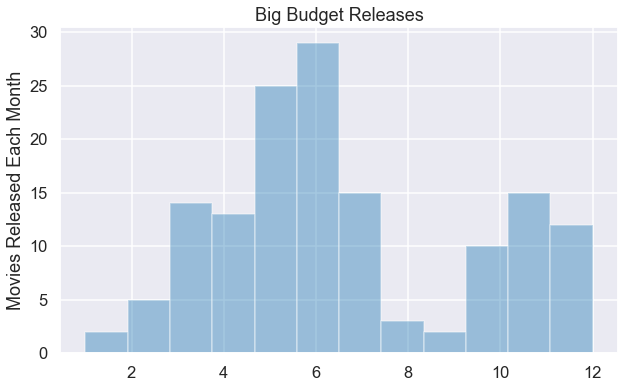

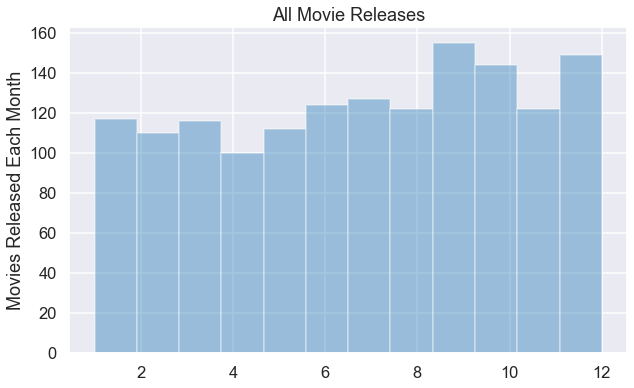

In [25]:
df_month2, fig2, ax2 = release_date_graph(df10, lower_quantile=0.9, upper_quantile=1, yaxis='budget', graph_type='dist')  # can send in df5 or df10 for last 5 or 10 years of data
df_month1, fig1, ax1 = release_date_graph(df10, lower_quantile=0, upper_quantile=1, yaxis='budget', graph_type='dist')  # can send in df5 or df10 for last 5 or 10 years of data



ax1.set_title("All Movie Releases")
ax2.set_title("Big Budget Releases")

## Profitability of films


We will make another column in our data which will be the ratio of revenue to profit.  This will identify what genre returns the most on the investment.

Text(0.5, 1.0, 'Expected Returns by Genre')

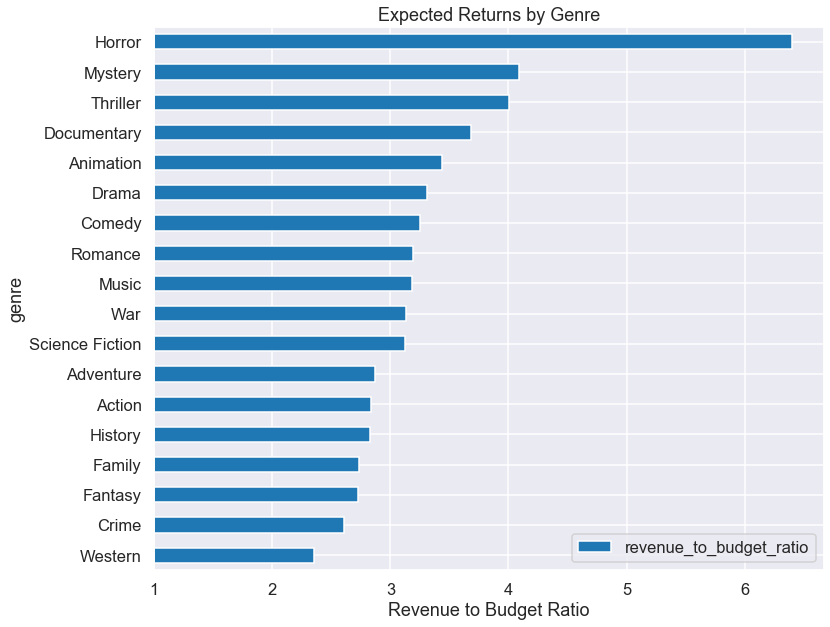

In [46]:
df_genres_grouped2 = df_gen_exp.groupby(['genre']).mean().sort_values('revenue_to_budget_ratio')

df_gen_exp.reset_index()
                               
df_genres_grouped2 = df_genres_grouped2.drop(columns=['budget', 'revenue', 'release_year'])
df_genres_grouped2

ax = df_genres_grouped2.plot.barh(figsize=(12,10))


ax.set_xticklabels([x for x in range(1, 10)]) # set new labels

ax.set(xlabel='Revenue to Budget Ratio')
ax.set_title("Expected Returns by Genre")








Horror movies are by far the most profitable genre.  Many of the genres that demand large budgets are not dollar for dollar as profitable as the low budget genres.  

/Users/aaronlee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[Text(0, 0.5, 'Horror movies made')]

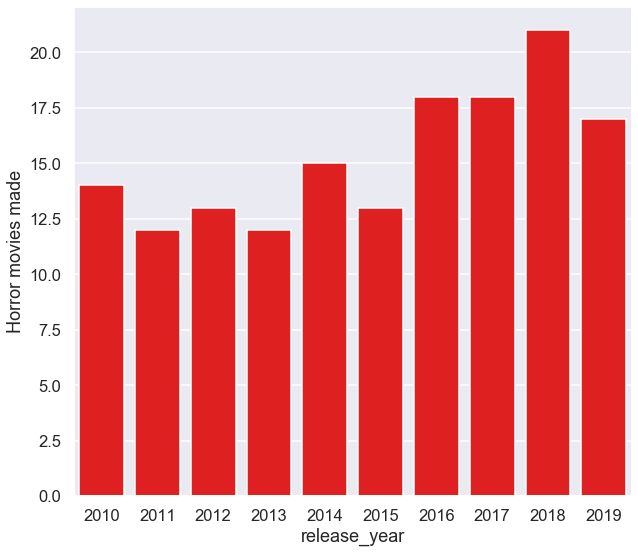

In [51]:
df_horror = df_gen_exp.loc[df_gen_exp['genre']=='Horror']
df_horror['release_year'] = df_horror.loc[:, 'release_date'].map(lambda x: x.year)
df_horror = df_horror.groupby(['release_year']).count()
df_horror = df_horror.reset_index()
df_horror

plt.figure(figsize=(10,9))
ax = sns.barplot(data=df_horror, x='release_year', y='genre', color='red')
ax.set(ylabel='Horror movies made')

# Audience score 
After alll this exploration, we haven't yet looked at audience scores predictor. It surprisingly showed only a weak correlation with revenue.  Budgets seem to drive revenue, especially on the high end.  Perhaps some movies and genres have particularly high return on investment.  

Do we even need to make highly rated movies, or is the big budget spectacle enough to predict success.


/Users/aaronlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(0, 35)

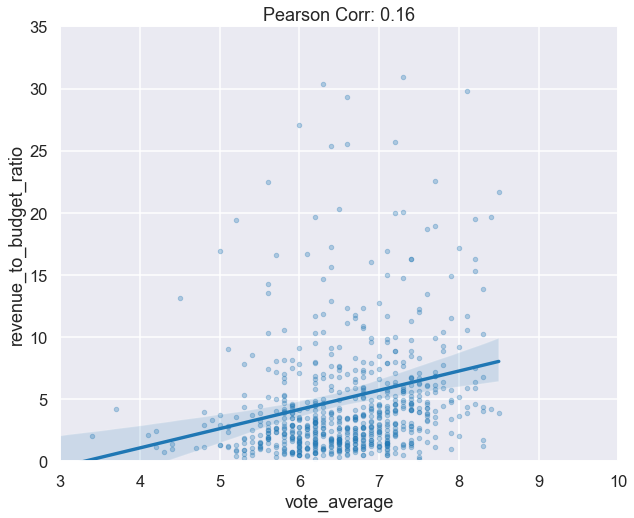

In [29]:
df5['revenue_to_budget_ratio'] = df5['revenue'] / df5['budget']

# make regression plot
plt.figure(figsize=(10,8))
ax = sns.regplot(data=df5, 
                 x='vote_average',
                 y='revenue_to_budget_ratio', 
                 scatter_kws={"s":20,'alpha':0.3},
                 order=1,
                  )

# annotate with pval
pval = df5[['vote_average', 'revenue_to_budget_ratio']].corr(method ='pearson').iloc[0,1]
ax.set_title('Pearson Corr: {:.2f}'.format(pval))
ax.set_xlim(3,10)
ax.set_ylim(0,35)


The graph above is cut off in x and y as there were no movies with less than 3 stars and several outliers (extreme overperformers) are not shown, having revenue_to_budget ratios close to 100.  Among those are the movie Get Out (for reference).  Star ratings above 7/10 seem to almost universally show profitability.  

One of the more surprising conclusions from this study is that audience score (vote_average) has only a weak correlation (Pearson 0.156) with the profitibility of a film (regardless of budget).  
